<a href="https://colab.research.google.com/github/brunacpg/MVP-Machine-Learning/blob/main/MVP_Ci%C3%AAncia_de_dados_e_Analytcs_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP - Análise de Sentimentos e Extração de Tópicos das Avaliações da Amazon

## 1. Definição do Problema

### 1.1 Objetivo
O objetivo deste projeto é aplicar técnicas de **Processamento de Linguagem Natural (NLP)** para analisar as avaliações dos consumidores da Amazon. As análises incluem:

- **Análise de Sentimentos**: Identificar a polaridade das avaliações (positiva, neutra ou negativa).
- **Extração de Tópicos**: Descobrir os principais temas abordados nas avaliações (ex.: qualidade, preço, entrega).

Esses insights poderão ser usados para:
- Melhorar a experiência do cliente.
- Oferecer feedback direto para aprimorar produtos e serviços.

**Métricas de sucesso sugeridas**:
1. **Análise de Sentimentos**: Obter pelo menos 85% de precisão na classificação.
2. **Extração de Tópicos**: Identificar ao menos 3 tópicos principais com uma relevância acima de 70%.

---

### 1.2 Descrição do Problema
Os consumidores frequentemente compartilham opiniões detalhadas em avaliações na Amazon, mas essas informações são não estruturadas e difíceis de analisar em escala. Usaremos técnicas de NLP para responder a perguntas como:
- Quais fatores levam à satisfação ou insatisfação dos clientes?
- Quais palavras-chave são mais comuns em avaliações positivas e negativas?
- Como as avaliações se correlacionam com a pontuação geral dos produtos?

---

### 1.3 Premissas e Hipóteses

**Premissas**:
1. Avaliações com pontuação alta (4 ou 5) representam satisfação, enquanto pontuações baixas (1 ou 2) indicam insatisfação.
2. Textos das avaliações contêm informações valiosas sobre aspectos específicos dos produtos.

**Hipóteses**:
1. Palavras relacionadas a "qualidade", "preço" e "funcionalidade" aparecem frequentemente em avaliações positivas.
2. Problemas de "durabilidade" ou "descrições enganosas" são recorrentes em avaliações negativas.

**Validação das Hipóteses**:
- Realizaremos uma análise de frequência de palavras em cada categoria de sentimento.
- Compararemos os tópicos extraídos com as hipóteses iniciais.

---

### 1.4 Restrições e Condições

- **Tamanho do Dataset**: Contém 28.423 avaliações, sendo necessário considerar estratégias de amostragem.
- **Recursos Computacionais**: Modelos NLP podem ser computacionalmente caros. Priorizaremos eficiência com técnicas como:
  - **TF-IDF** para vetorização de texto.
  - **Modelos pré-treinados** para reduzir o custo computacional.
  - **Amostragem** para trabalhar com dados menores durante a prototipação.

---

### Conclusão da Estrutura
Essa estrutura segue corretamente o objetivo de um MVP para análise de sentimentos e extração de tópicos com NLP.
- Está alinhada com os requisitos de um projeto acadêmico ou prático.
- Permite aprofundar nas etapas de análise e validação com modelos.






# **Bloco 1: Importação de Bibliotecas**

Explicação: Neste bloco, importamos todas as bibliotecas necessárias para o projeto, incluindo:

Manipulação e análise de dados (pandas, numpy).
Processamento de texto (tensorflow.keras, sklearn).
Visualização de dados (matplotlib).

In [78]:
# Importação de bibliotecas
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# **Bloco 2: Carregar e Preparar os Dados**

Explicação:

Carregamos o dataset e realizamos o pré-processamento:
Filtramos as colunas relevantes (Score e Text).
Removemos valores nulos e duplicados.
Excluímos avaliações neutras (Score == 3).
Mapeamos as pontuações para rótulos binários: 0 (negativo) e 1 (positivo).
Exibimos a distribuição dos sentimentos.

In [79]:
# 1. Carregar e preparar os dados
df = pd.read_csv('amostra.csv')

# Contar as linhas antes do tratamento
initial_count = len(df)

# Filtrar colunas relevantes
df = df[['Score', 'Text']]

# Remover valores nulos e duplicados
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# Contar as linhas após o tratamento
final_count = len(df)
print(f"Linhas removidas: {initial_count - final_count}")
print(f"Linhas restantes: {final_count}")

# Excluir avaliações neutras
df = df[df['Score'] != 3]

# Mapear Score para Sentimento (0: Negativo, 1: Positivo)
df['Sentiment'] = df['Score'].map({1: 0, 2: 0, 4: 1, 5: 1})

# Exibir a distribuição de sentimentos
print("Distribuição dos Sentimentos:")
print(df['Sentiment'].value_counts())


Linhas removidas: 1309
Linhas restantes: 27114
Distribuição dos Sentimentos:
Sentiment
1    21233
0     3862
Name: count, dtype: int64


<ipython-input-79-5c20a615e376>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment'] = df['Score'].map({1: 0, 2: 0, 4: 1, 5: 1})


**Bloco 3: Tokenização e Padronização do Texto**

Explicação:

Usamos o Tokenizer para transformar os textos em sequências numéricas.
Aplicamos padding para uniformizar o comprimento das sequências.
Exibimos os formatos finais dos tensores de entrada (X_padded) e dos rótulos (y).



In [80]:
# 2. Configuração do Tokenizer
max_words = 10000  # Tamanho do vocabulário
max_len = 100  # Comprimento máximo das sequências

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Text'])

# Converter textos em sequências
X_seq = tokenizer.texts_to_sequences(df['Text'])

# Aplicar padding nas sequências
X_padded = pad_sequences(X_seq, maxlen=max_len, padding='post', truncating='post')

# Definir rótulos
y = df['Sentiment'].values

# Verificar o formato das sequências e rótulos
print(f"Formato de X_padded: {X_padded.shape}")
print(f"Formato de y: {y.shape}")


Formato de X_padded: (25095, 100)
Formato de y: (25095,)


# **Bloco 4: Divisão dos Dados**

Explicação:

Dividimos os dados entre treino e teste (80/20) para avaliar o desempenho do modelo.

In [81]:
# Divisão dos dados entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Exibir tamanhos dos conjuntos
print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")


Tamanho do conjunto de treino: (20076, 100)
Tamanho do conjunto de teste: (5019, 100)


# **Bloco 4.1: Faz Sentido Utilizar Validação Cruzada?**

Explicação:

Validação cruzada (K-Fold) faz sentido em muitos problemas, mas no caso de modelos de Deep Learning, geralmente não é usada diretamente porque:
O treinamento é computacionalmente caro e a validação cruzada multiplicaria o custo.
1. Deep Learning é computacionalmente caro e validação cruzada não é prática.
2. Usaremos validation_split no treinamento para simular validação cruzada de forma eficiente.


# **Bloco 5: Construção e Compilação do Modelo**

Explicação:

Criamos o modelo LSTM:

1.   Embedding: Representação densa das palavras.
2.  LSTM: Captura o contexto sequencial.
3.  Dense: Camada de saída binária

Compilamos o modelo usando:

1. Adam: Otimizador eficiente.
2. Binary Crossentropy: Função de perda para classificação binária.

In [85]:
# 4. Construção do modelo LSTM
embedding_dim = 128  # Dimensão dos embeddings
lstm_units = 64  # Unidades na camada LSTM

# Construção do modelo
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim),  # Camada de embeddings
    LSTM(lstm_units, return_sequences=False),  # Camada LSTM
    Dense(1, activation='sigmoid')  # Camada de saída para classificação binária
])

# Compilar o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Forçar a construção do modelo para definir as dimensões de entrada
model.build(input_shape=(None, max_len))  # None é o batch size, max_len é o comprimento das sequências

# Exibir o resumo do modelo
model.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ (None, 100, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

# **Bloco 6: Treinamento do Modelo**

Explicação:

Treinamos o modelo por 5 épocas, usando 20% dos dados de treino como conjunto de validação.

In [86]:
# 5. Treinamento com validation_split
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2  # 20% dos dados de treino são usados para validação
)

# Exibir os dados de validação durante o treinamento
print("Histórico do Treinamento com Validação:")
print(history.history)

Epoch 1/5
502/502 ━━━━━━━━━━━━━━━━━━━━ 57s 109ms/step - accuracy: 0.8386 - loss: 0.4448 - val_accuracy: 0.8404 - val_loss: 0.4362
Epoch 2/5
502/502 ━━━━━━━━━━━━━━━━━━━━ 73s 91ms/step - accuracy: 0.8552 - loss: 0.4034 - val_accuracy: 0.8404 - val_loss: 0.4299
Epoch 3/5
502/502 ━━━━━━━━━━━━━━━━━━━━ 102s 130ms/step - accuracy: 0.8621 - loss: 0.3671 - val_accuracy: 0.8755 - val_loss: 0.3044
Epoch 4/5
502/502 ━━━━━━━━━━━━━━━━━━━━ 78s 122ms/step - accuracy: 0.9296 - loss: 0.1977 - val_accuracy: 0.9034 - val_loss: 0.2548
Epoch 5/5
502/502 ━━━━━━━━━━━━━━━━━━━━ 65s 89ms/step - accuracy: 0.9581 - loss: 0.1221 - val_accuracy: 0.9011 - val_loss: 0.2626
Histórico do Treinamento com Validação:
{'accuracy': [0.8466376066207886, 0.8535491824150085, 0.8737857937812805, 0.9280199408531189, 0.9560398459434509], 'loss': [0.42956608533859253, 0.4044969379901886, 0.3300078809261322, 0.19575798511505127, 0.12533511221408844], 'val_accuracy': [0.8403884172439575, 0.8403884172439575, 0.8754979968070984, 0.9033

In [87]:
import pandas as pd

# Salvar o histórico do treinamento em CSV
history_df = pd.DataFrame(history.history)
history_df.to_csv('historico_treinamento.csv', index=False)

print("Histórico do treinamento salvo como 'historico_treinamento.csv'.")


Histórico do treinamento salvo como 'historico_treinamento.csv'.


# **Bloco 7: Avaliação do Modelo no Conjunto de Teste**

Explicação:

Avaliamos o desempenho no conjunto de teste para calcular a perda e a acurácia final.

In [88]:
# 6. Avaliação do modelo no conjunto de teste
loss, accuracy = model.evaluate(X_test, y_test)

# Exibir a acurácia no conjunto de teste
print(f"Acurácia no conjunto de teste: {accuracy:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9028 - loss: 0.2539
Acurácia no conjunto de teste: 0.8988


# **Bloco 8: Relatório de Classificação e Matriz de Confusão**

Explicação:

Geramos um relatório de classificação para verificar métricas detalhadas (precisão, recall, F1-score).
Exibimos uma matriz de confusão para visualizar o desempenho.

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.70      0.61      0.65       783
           1       0.93      0.95      0.94      4236

    accuracy                           0.90      5019
   macro avg       0.82      0.78      0.80      5019
weighted avg       0.89      0.90      0.90      5019



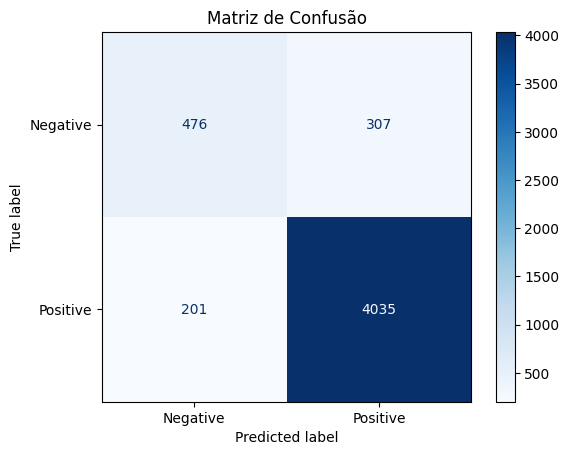

In [89]:
# Relatório de classificação e matriz de confusão
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Relatório de classificação
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão")
plt.show()



**Bloco 9: Visualização das Curvas de Treinamento**

Explicação:

Plotamos as curvas de acurácia e perda para identificar sinais de underfitting ou overfitting.

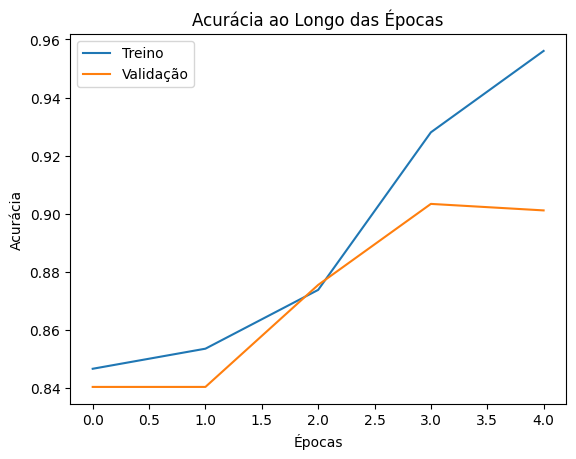

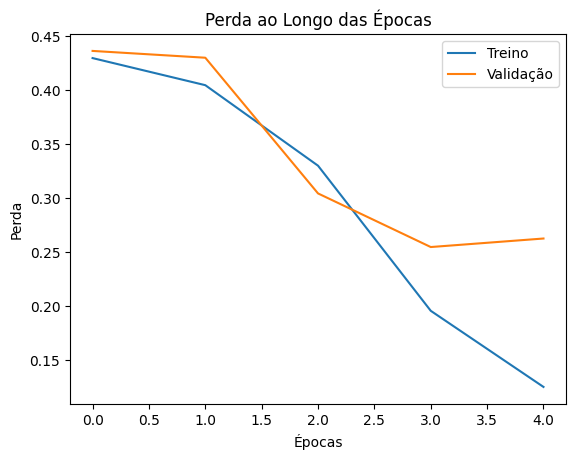

In [90]:
# Plotar a acurácia
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia ao Longo das Épocas')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

# Plotar a perda
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda ao Longo das Épocas')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()
